# Proejct: Continuous Control

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from config import Config, DeviceConfig

from util import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

DeviceConfig.device = device
DeviceConfig.device

device(type='cuda', index=0)

# Create UnityEnvironment
Create Unity Environment If you have a Linux environment, create an environment without a screen.

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import platform

if platform.system() == 'Linux':
    #env = UnityEnvironment(file_name='./Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
    env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')
elif platform.system() == 'Darwin':
    env = UnityEnvironment(file_name='./Reacher.app')
    
env

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

brain_name, brain

('ReacherBrain', <unityagents.brain.BrainParameters at 0x7fa7c16c2828>)

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [55]:
%load_ext autoreload
%autoreload 2

from model import ActorCriticNet
from agent import PPOAgent
from typing import NamedTuple
from config import Config, DeviceConfig

config = Config(num_workers=num_agents)

class UnityEnvironmentStepTask:
    def __init__(self, env, brain_name):
        self.env = env
        self.brain_name = brain_name
        
    def step(self, actions):
        env_info = self.env.step(actions)[self.brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        terminals = np.array([1 if done else 0 for done in env_info.local_done])
        
        return next_states, rewards, terminals, None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def run(env, brain_name, network: ActorCriticNet):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions, _, _, _ = network(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    return np.mean(scores)
    
def ppo(train, env, brain_name, network, config, weight_filename):
    if train:
        opt = optim.Adam(network.parameters(), 
                         config.adam_learning_rate, 
                         eps=config.adam_epsilon)
        agent = PPOAgent(config=config, 
                         env=env, 
                         brain_name=brain_name,
                         task_fn=UnityEnvironmentStepTask(env=env, brain_name=brain_name), 
                         network=network, 
                         opt=opt,
                         device=device)
        all_scores = []
        means = []
        last_max = 30.0
        
        for i in range(config.episode_count):
            agent.step()
            
            this_episode_mean_score = run(env, brain_name, network)
            last_mean = np.mean(np.array(all_scores[-100:])) if len(all_scores) > 100 else np.mean(np.array(all_scores))
            all_scores.append(this_episode_mean_score)
            means.append(last_mean)
            
            if last_mean > last_max:
                torch.save(network.state_dict(), weight_filename)
                last_max = last_mean
                           
            print('Episode: {} Total score: {} Average Score: {}'.format(i + 1, this_episode_mean_score, last_mean))
            
        return all_scores, means
    else:
        weight = torch.load(weight_filename, map_location=device)
        network.load_state_dict(weight)
        
        score = run(env, brain_name, network)
        return [score], [score]

When finished, you can close the environment.

In [ ]:
weight_filename = 'ppo_checkpoint_batch_32.pth'

DeviceConfig.device = device
config_batch32 = Config(num_workers=num_agents, mini_batch_size=32)

train_network = ActorCriticNet(state_size=state_size, 
                               action_size=action_size, 
                               hidden_size=config_batch32.hidden_size).to(device)

all_scores, average_scores = ppo(train=True, env=env, brain_name=brain_name, network=train_network, config=config_batch32, weight_filename=weight_filename)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1036: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 1 Total score: 0.3399999924004078 Average Score: nan
Episode: 2 Total score: 0.5444999878294766 Average Score: 0.3399999924004078
Episode: 3 Total score: 0.5454999878071248 Average Score: 0.4422499901149422
Episode: 4 Total score: 0.7334999836049974 Average Score: 0.47666665601233643
Episode: 5 Total score: 0.9724999782629311 Average Score: 0.5408749879105017
Episode: 6 Total score: 1.2409999722614884 Average Score: 0.6271999859809876
Episode: 7 Total score: 1.2684999716468155 Average Score: 0.7294999836944044
Episode: 8 Total score: 1.5344999657012521 Average Score: 0.8064999819733203
Episode: 9 Total score: 1.3009999709203839 Average Score: 0.8974999799393117
Episode: 10 Total score: 1.9739999558776617 Average Score: 0.942333312270542
Episode: 11 Total score: 1.8834999579004943 Average Score: 1.045499976631254
Episode: 12 Total score: 2.07549995360896 Average Score: 1.1216817931102758
Episode: 13 Total score: 2.6319999411702155 Average Score: 1.2011666398184995
Episode: 14 T

In [9]:
weight_filename = 'ppo_checkpoint.pth'

train_network = ActorCriticNet(state_size=state_size, 
                               action_size=action_size, 
                               hidden_size=config.hidden_size).to(device)

all_scores, average_scores = ppo(train=True, env=env, brain_name=brain_name, network=train_network, config=config, weight_filename=weight_filename)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1036: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 1 Total score: 0.12349999723955989 Average Score: nan
Episode: 2 Total score: 0.18299999590963126 Average Score: 0.12349999723955989
Episode: 3 Total score: 0.2614999941550195 Average Score: 0.15324999657459557
Episode: 4 Total score: 0.6489999854937196 Average Score: 0.18933332910140355
Episode: 5 Total score: 0.9924999778158963 Average Score: 0.30424999319948254
Episode: 6 Total score: 0.9664999783970416 Average Score: 0.44189999012276526
Episode: 7 Total score: 1.2679999716579915 Average Score: 0.5293333215018113
Episode: 8 Total score: 1.4209999682381749 Average Score: 0.6348571286669801
Episode: 9 Total score: 1.6944999621249734 Average Score: 0.7331249836133793
Episode: 10 Total score: 1.8134999594651162 Average Score: 0.8399444256702231
Episode: 11 Total score: 2.179999951273203 Average Score: 0.9372999790497124
Episode: 12 Total score: 2.5274999435059726 Average Score: 1.0502727037973025
Episode: 13 Total score: 3.0689999314025043 Average Score: 1.173374973773025
Episo

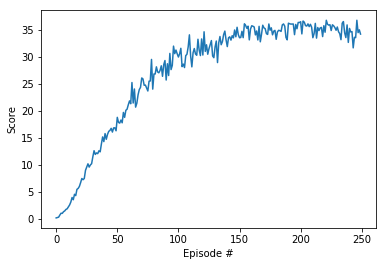

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(all_scores)), all_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

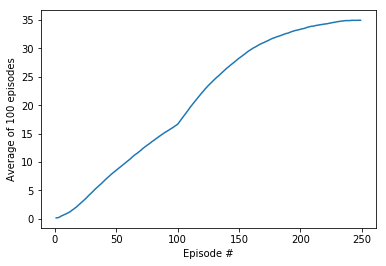

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_scores)), average_scores)
plt.ylabel('Average of 100 episodes')
plt.xlabel('Episode #')
plt.show()

In [23]:
trained_network = ActorCriticNet(state_size=state_size, 
                                 action_size=action_size,
                                 hidden_size=512).to(torch.device("cpu"))

all_scores, average_scores = ppo(train=False, env=env, brain_name=brain_name, network=trained_network, config=config, weight_filename=weight_filename)

all_scores, average_scores

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1036: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


([33.29449925580993], [33.29449925580993])

In [ ]:
env.close()